# <font face = 'Palatino Linotype' color = '#274472'> Predicting  using Machine Learning <font/>
### <font face = 'Palatino Linotype' color = '#5885AF'> Data Scientists: Paolo Hilado and Alison Danvers<font/>

# Scenario

Data Scientists were hired to determine upcoming tennis players who are likely to not progress into the second week of the Grand Slam Tournaments. After being identified, these players could undergo interventions specific to their techniques or tactics needing improvement. Historical data on players' match performances, sourced from University of California Irvine, was utilized to train a machine learning model to address this problem.    

# Dataset

The data was explored and pre-processed preparing for machine learning modelling. Variables relevant to addressing the problem were considered as explanatory variables for the model which includes the following:

- FNL - Final Number of Games Won
- FSP - First Serve Percentage
- FSW - First Serve Won
- SSP - Second Serve Percentage
- SSW - Second Serve Won
- ACE - Aces Won by Player
- DBF - Double Fault Committed by Player
- BPC - Break Points Created by Player
- BPW - Break Points Won by Player
- NPA - Net Points Attempted 
- NPW - Net Points Won

These were the variables that had data through out the 4 Tournaments: US Open, Australian Open, French Open, and Wimbledon. Few missing cases on the dataset were addressed using K-Nearest Neighbor Imputation technique. Undersampling was utilized to reduce the imbalance in the train set while ensuring that it still has more observations than the test set. These were done after the 70-30 train-test split to avoid data leakage. 

The response variable labeled "C2" refers to the classification of players. It is an engineered feature which includes two levels for classification:

- 1 - These are players who did not make it to the semifinals or played in the quarterfinals and lost.
- 2 - These are players who at least made it to the semifinals.

In [1]:
# Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import copy
import pickle
import time
from datetime import datetime

# Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, precision_recall_curve, ConfusionMatrixDisplay, auc

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the training data set.
train = pd.read_excel("df_mentennis_2013_imputed_train-Undersample.xlsx", sheet_name= "Sheet1")
train.head(3)

,C2,FNL,FSP,FSW,SSP,SSW,ACE,DBF,BPC,BPW,NPA,NPW
0,1,3,56,60,44,31,5,3.0,8,12,27.0,29.0
1,1,3,60,52,40,32,3,2.0,6,10,11.0,22.0
2,1,3,62,54,38,25,7,9.0,4,7,22.0,28.0


In [11]:
# Load the test data set.
test = pd.read_excel("df_mentennis_2013_imputed_test.xlsx", sheet_name= "Sheet1")
test = test.iloc[:, 2:]
test.head(3)

,C2,FNL,FSP,FSW,SSP,SSW,ACE,DBF,BPC,BPW,NPA,NPW
0,1,2,52,51,48,30,9,4,3,6,37.0,50.0
1,1,2,78,84,22,15,1,3,7,10,14.0,23.0
2,1,3,58,39,42,19,10,1,4,7,12.0,13.0


In [12]:
# Separate the explanatory variables from the response variable.
x_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
x_train.head(2)

,FNL,FSP,FSW,SSP,SSW,ACE,DBF,BPC,BPW,NPA,NPW
0,3,56,60,44,31,5,3.0,8,12,27.0,29.0
1,3,60,52,40,32,3,2.0,6,10,11.0,22.0


In [13]:
# Separate the explanatory variables from the response variable.
x_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]
x_test.head(2)

,FNL,FSP,FSW,SSP,SSW,ACE,DBF,BPC,BPW,NPA,NPW
0,2,52,51,48,30,9,4,3,6,37.0,50.0
1,2,78,84,22,15,1,3,7,10,14.0,23.0


In [6]:
# Identify the labels of the explanatory variables.
x_train.columns

Index(['FNL', 'FSP', 'FSW', 'SSP', 'SSW', 'ACE', 'DBF', 'BPC', 'BPW', 'NPA',
       'NPW'],
      dtype='object')

In [14]:
# Standardize all the continuous variables for the train set.
from sklearn.preprocessing import StandardScaler

# Assigning feature labels to variable continuous_vars.
continuous_vars = ['FNL', 'FSP', 'FSW', 'SSP', 'SSW', 'ACE', 'DBF', 'BPC', 'BPW', 'NPA',
       'NPW']

# Initialize StandardScaler.
scaler = StandardScaler()

# Fit scaler to the continuous variables and transform them.
x_train[continuous_vars] = scaler.fit_transform(x_train[continuous_vars])
x_train.head(5)

,FNL,FSP,FSW,SSP,SSW,ACE,DBF,BPC,BPW,NPA,NPW
0,0.881573,-0.784900,0.608683,0.784900,1.162346,-0.605236,-0.346477,0.667991,0.651616,0.484793,0.350578
1,0.881573,-0.250558,0.142672,0.250558,1.281360,-0.901832,-0.681558,0.178793,0.303970,-0.724695,-0.195012
2,0.881573,0.016613,0.259175,-0.016613,0.448265,-0.308640,1.664010,-0.310405,-0.217499,0.106828,0.272637
3,0.881573,-0.384143,0.899941,0.384143,1.995442,-1.050129,0.993847,1.401787,3.085138,0.242895,0.771462
4,-0.686553,-1.052071,-0.090334,1.052071,1.043333,0.729445,-0.346477,1.157188,-1.086614,1.316316,-0.039129


In [15]:
# Standardize all the continuous variables for the test set.
from sklearn.preprocessing import StandardScaler

# Assigning feature labels to variable continuous_vars.
continuous_vars = ['FNL', 'FSP', 'FSW', 'SSP', 'SSW', 'ACE', 'DBF', 'BPC', 'BPW', 'NPA',
       'NPW']

# Fit scaler to the continuous variables and transform them.
x_test[continuous_vars] = scaler.transform(x_test[continuous_vars])
x_test.head(5)

,FNL,FSP,FSW,SSP,SSW,ACE,DBF,BPC,BPW,NPA,NPW
0,0.097510,-1.319242,0.084420,1.319242,1.043333,-0.012044,-0.011396,-0.555003,-0.391322,1.240723,1.987350
1,0.097510,2.153981,2.006718,-2.153981,-0.741872,-1.198427,-0.346477,0.423392,0.303970,-0.497916,-0.117070
2,0.881573,-0.517729,-0.614597,0.517729,-0.265817,0.136253,-1.016640,-0.310405,-0.217499,-0.649102,-0.896485
3,0.097510,-1.185656,0.026169,1.185656,0.805305,1.767530,2.669253,-0.310405,-0.391322,0.303370,0.366167
4,-1.470615,0.283784,-1.022357,-0.283784,-0.503845,-1.050129,0.323685,-1.044201,-0.217499,-0.800288,-0.428836


# Training and Evaluating the Machine Learning Model
Since the problem focuses on identifying players who are unlikely to make it to the second week, the performance metric for the model considers the True Positive as: Historical data presenting players who did not make it to the second week and the model had it correctly predicted. Cognizant of the machine learning problem, Recall is the evaluation metric that was preferred.

# Decision Tree Model

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

# Define the Parameters for the Decision Tree Model.
param_grid = {
    'criterion': ['gini', 'entropy'],       # Split criterion ('gini' or 'entropy')
    'max_depth': [3, 5, 10, 15],         # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],          # Minimum number of samples required to be at a leaf node
    'max_features': ['log2', 'sqrt'],       # Number of features to consider when looking for the best split
    'random_state': [42]                    # Random seed for reproducibility
}

# Load the Decision Tree model.
classifier = DecisionTreeClassifier()

# 
# Create a Recall scoring function.
recall_scorer = make_scorer(recall_score, pos_label =1)

# Create a GridSearchCV instance.
grid_search = GridSearchCV(classifier, param_grid, scoring=recall_scorer, cv=5)

# Doing a grid search to get the best performing model.
grid_search.fit(x_train.values, y_train.values)

# Get the parameters and recall score of the best performing model.
best_params = grid_search.best_params_
best_recall_scorer = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best CV Recall Score:", best_recall_scorer)

Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42}
Best CV Recall Score: 0.9386039132734003


Test f1 Score = 0.8953488372093024
Test recall Score = 0.850828729281768
Test precision Score = 0.9447852760736196
tp: 154 fn: 27 fp: 9 tn: 7


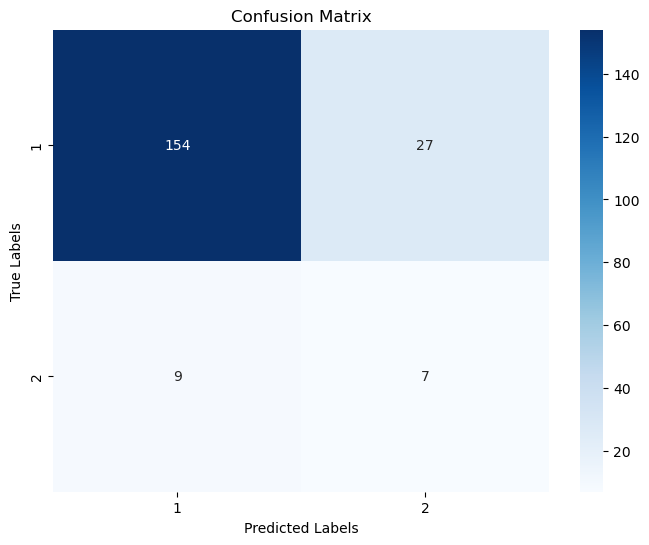

In [18]:
# Let us fit the Decision Tree Model using the hyperparameters for our best model
from sklearn import tree
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make predictions using the best model on the test set.
y_pred = grid_search.predict(x_test)

# Calculate model performance such as F1, Recall, and Precision. 
from sklearn import metrics
print("Test f1 Score =",metrics.f1_score(y_test, y_pred, pos_label = 1))
print("Test recall Score =",metrics.recall_score(y_test, y_pred, pos_label = 1))
print("Test precision Score =",metrics.precision_score(y_test, y_pred, pos_label = 1))

# Define class labels.
class_labels = np.unique(y_test)

# Create a confusion matrix.
cm = confusion_matrix(y_test, y_pred, labels=class_labels)

# Proper labelling of outcomes.
tp, fn, fp, tn= confusion_matrix(y_test, y_pred, labels=class_labels).ravel()
print("tp:", tp,"fn:", fn,"fp:",fp,"tn:", tn )

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Grid Search for Logistic Regression.
# Define the parameters for the model.
param_grid = {
    'penalty': ['l1', 'l2'],            # Regularization type ('l1' or 'l2')
    'C': [0.01, 0.1, 1, 10, 100],       # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],    # Algorithm to use for optimization
    'max_iter': [50, 100, 200, 300],        # Maximum number of iterations
    'random_state': [42]                # Random seed for reproducibility
}

# Load a Logistic Regression model.
logreg = LogisticRegression(n_jobs=-1)

# Create a Recall scoring function.
recall_scorer = make_scorer(recall_score, pos_label =1)

# Create a GridSearchCV instance.
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring=recall_scorer)

# Doing a grid search to get the best performing model.
grid_search.fit(x_train, y_train)

# Get the best parameters and recall score of the best performing model.
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Show the results
print("Best Hyperparameters found: " + str(best_params))
print("Best CV Recall Score: " + str(best_score))

Best Hyperparameters found: {'C': 0.01, 'max_iter': 50, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}
Best CV Recall Score: 1.0


Test f1 Score = 0.9576719576719577
Test recall Score = 1.0
Test precision Score = 0.9187817258883249
tp: 181 fn: 0 fp: 16 tn: 0


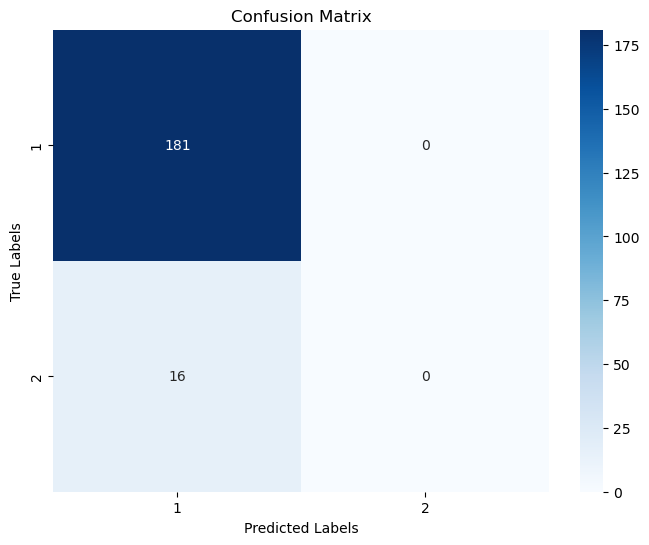

In [20]:
# Let us fit the Logistic Regression Model using the hyperparameters for our best model
from sklearn import tree
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Print the Decision Tree Model performance on our test set.
y_pred = grid_search.predict(x_test)

# Calculate model performance such as F1, Recall, and Precision. 
from sklearn import metrics
print("Test f1 Score =",metrics.f1_score(y_test, y_pred, pos_label = 1))
print("Test recall Score =",metrics.recall_score(y_test, y_pred, pos_label = 1))
print("Test precision Score =",metrics.precision_score(y_test, y_pred, pos_label = 1))


# Define class labels.
class_labels = np.unique(y_test)

# Compute confusion matrix.
cm = confusion_matrix(y_test, y_pred, labels=class_labels)

# Proper labelling of outcomes.
tp, fn, fp, tn= confusion_matrix(y_test, y_pred, labels=class_labels).ravel()
print("tp:", tp,"fn:", fn,"fp:",fp,"tn:", tn )

# Create a heatmap of the confusion matrix.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# MultiLayer Perceptron

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.neural_network import MLPClassifier

# Define the parameters for the MLP Model.
param_grid = {"hidden_layer_sizes": [(2), (3), (4), (5), (10)], # we consider a small number for hidden layers as we have a small number of observations
              "activation": ['identity', 'tanh', 'logistic', 'relu'],
              "solver": ['adam', 'sgd'],
              "max_iter": [100, 200, 400],
              "alpha": [0.01, 0.001],
              "random_state": [42]}

# Specifying our Classifier.
classifier = MLPClassifier(early_stopping=True)

# Create a Recall scoring function.
recall_scorer = make_scorer(recall_score, pos_label =1)

# Create a GridSearchCV instance.
grid_search = GridSearchCV(classifier, param_grid, scoring=recall_scorer, cv=5)

# Using GridSearchCV to determine the best model.
grid_search.fit(x_train, y_train)

# Get the best parameters and best F1 score
best_params = grid_search.best_params_
best_recall_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best CV Recall Score:", best_recall_score)

Best Parameters: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 2, 'max_iter': 100, 'random_state': 42, 'solver': 'adam'}
Best CV Recall Score: 1.0


Test f1 Score = 0.9576719576719577
Test recall Score = 1.0
Test precision Score = 0.9187817258883249
tp: 181 fn: 0 fp: 16 tn: 0


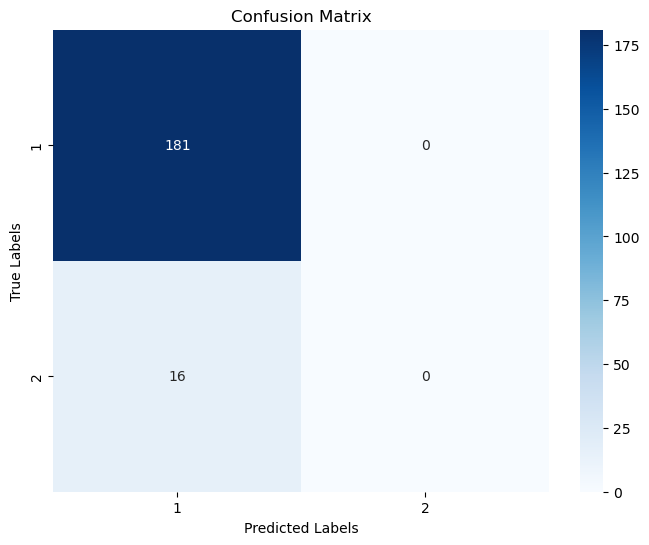

In [22]:
from sklearn import tree
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make predictions using the best model on the test set.
y_pred = grid_search.predict(x_test)

# Calculate model performance such as F1, Recall, and Precision. 
from sklearn import metrics
print("Test f1 Score =",metrics.f1_score(y_test, y_pred, pos_label = 1))
print("Test recall Score =",metrics.recall_score(y_test, y_pred, pos_label = 1))
print("Test precision Score =",metrics.precision_score(y_test, y_pred, pos_label = 1))

# Define class labels.
class_labels = np.unique(y_test)

# Compute confusion matrix.
cm = confusion_matrix(y_test, y_pred, labels=class_labels)

# Proper labelling of outcomes.
tp, fn, fp, tn= confusion_matrix(y_test, y_pred, labels=class_labels).ravel()
print("tp:", tp,"fn:", fn,"fp:",fp,"tn:", tn )

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Random Forest

In [25]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, f1_score

# Load the Random Forest Classifier Model.
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Define the parameters of the Random Forest Classifier for Hyperparameter Tuning.
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create a Recall scoring function.
recall_scorer = make_scorer(recall_score, pos_label =1)

# Setup the grid search.
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=recall_scorer)

# Using GridSearchCV to determine the best model.
grid_search.fit(x_train, y_train)

# Get the best parameters and its Recall score
best_params = grid_search.best_params_
best_recall_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best CV Recall Score:", best_recall_score)

Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Best CV Recall Score: 0.9709148598625067


Test f1 Score = 0.9392265193370166
Test recall Score = 0.9392265193370166
Test precision Score = 0.9392265193370166
tp: 170 fn: 11 fp: 11 tn: 5


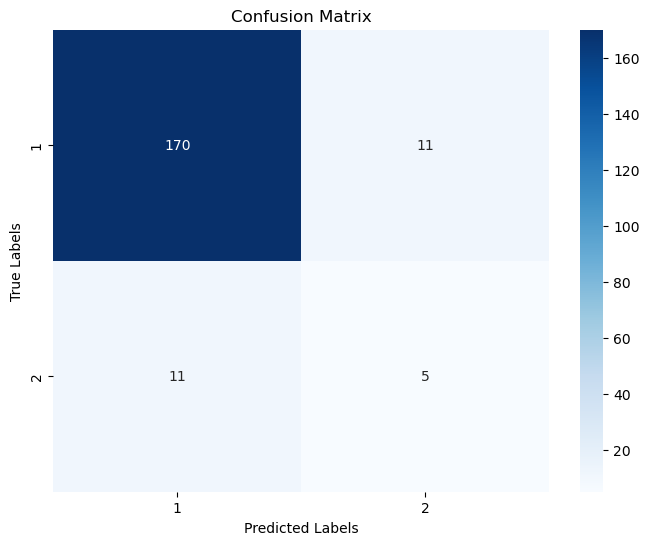

In [26]:
# Let us fit the Random Forest Model using the hyperparameters from out best model.

from sklearn import tree
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Make predictions using the model on the test set.
y_pred = grid_search.predict(x_test)


# Calculate model performance such as F1, Recall, and Precision. 
from sklearn import metrics
print("Test f1 Score =", metrics.f1_score(y_test, y_pred, pos_label=1))
print("Test recall Score =",metrics.recall_score(y_test, y_pred, pos_label = 1))
print("Test precision Score =",metrics.precision_score(y_test, y_pred, pos_label = 1))

# Define class labels
class_labels = np.unique(y_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=class_labels)

# Proper labelling of outcomes.
tp, fn, fp, tn= confusion_matrix(y_test, y_pred, labels=class_labels).ravel()
print("tp:", tp,"fn:", fn,"fp:",fp,"tn:", tn )

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [27]:
# Save a copy of the Random Forest Model.
import pickle
pickle.dump(grid_search, open('RFmodel.pkl', 'wb'))

# Conclusion

Machine learning models were trained in order to determine players who are unlikely to progress to higher levels of competition in the Tennis Grand Slam.  The problem considers the True Positive as players who did not make it to the second week in order to give the opportunity for more training interventions. As such, Recall is the evaluation metric that was preferred when comparing models. Decision tree, Logistic Regression, MultiLayer Perceptron, and Random Forest were trained to address this problem. Random Forest had better model performance in the cross validation (0.97) and the test data (0.94) compared to Decision tree (cv performance = 0.94, test data performance = 0.85). On the other hand, models like logistic regression and multilayer perceptron, despite having adequate model performance during cross validation, had a recall score of 1.0 in the test data which may be a concern for overfitting. Looking into the confusion matrix, these models performed poorly in determining true negatives. Overall, Random Forest seems like the model of choice in addressing the problem at hand using machine learning. 